In [1]:
import tensorflow as tf
from keras import layers
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
)

from keras import Model
from keras.models import Sequential

from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.optimizers import AdamW, RMSprop

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))

# Block 1
x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Block 2
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Block 3
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Classifier
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = Model(inputs, outputs)

In [4]:
optimizer = AdamW(learning_rate=0.0005)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5)

early_stop = EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor="val_accuracy",
    min_delta=0.001,
)

In [5]:


history = model.fit(
    train_images,
    train_labels,
    validation_split=0.2,
    epochs=25,
    batch_size=128,
    callbacks=[lr_scheduler, early_stop],
    verbose=1,
)

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.2968 - loss: 2.3950 - val_accuracy: 0.0980 - val_loss: 10.7455 - learning_rate: 5.0000e-04
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4986 - loss: 1.4708 - val_accuracy: 0.2753 - val_loss: 2.5963 - learning_rate: 5.0000e-04
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5822 - loss: 1.1774 - val_accuracy: 0.5912 - val_loss: 1.1569 - learning_rate: 5.0000e-04
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6325 - loss: 1.0405 - val_accuracy: 0.6350 - val_loss: 1.0428 - learning_rate: 5.0000e-04
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6732 - loss: 0.9254 - val_accuracy: 0.6551 - val_loss: 1.0001 - learning_rate: 5.0000e-04
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7055 - loss: 0.8457 - val_accuracy: 0.6882 - val_loss: 0.9123 - learning_rate: 5.0000e-04
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - a

In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

print(f"CNN Test Accuracy: {test_acc:.4f}")

CNN Test Accuracy: 0.7896


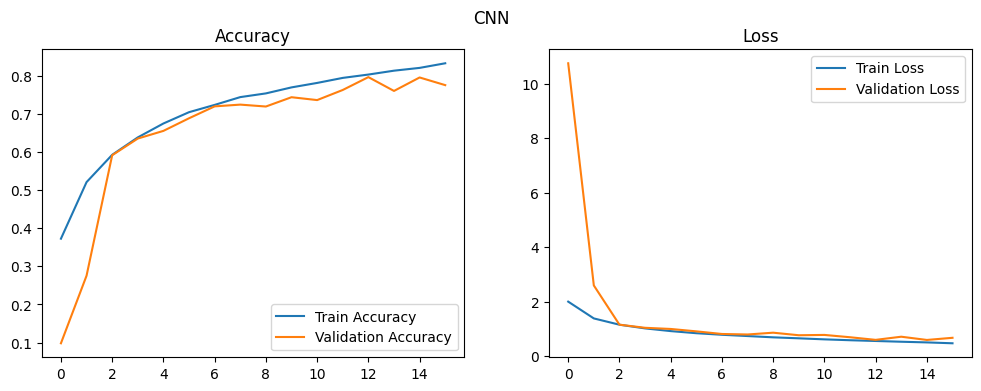

In [7]:

# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history(history, "CNN")

**CIFAR-10: Fine-tuning ResNet50 using Transfer Learning**

In [8]:
import tensorflow as tf
from keras import layers
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
)

from keras import Model
from keras.models import Sequential

from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.optimizers import AdamW, RMSprop

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test = tf.keras.applications.resnet50.preprocess_input(x_test)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Train data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [10]:
base_model = ResNet50(
    include_top=False, weights="imagenet"
)

# We freeze all but the last layers, so only the last layer's weights are trainable
for layer in base_model.layers[:143]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model = Sequential(
    [
        layers.Lambda(lambda image: tf.image.resize(image, (224, 224))),
        base_model,
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(10, activation="softmax"),
    ]
)

model.compile(optimizer=RMSprop(0.00002), loss="categorical_crossentropy", metrics=["accuracy"])

lr_schedule = (
    ReduceLROnPlateau(
        patience=1, factor=0.5, min_lr=1e-6, monitor="val_accuracy", verbose=1
    ),
)

es = EarlyStopping(
    monitor="val_accuracy", mode="max", patience=2, restore_best_weights=True
)

In [12]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    callbacks=[es, lr_schedule],
    validation_split=0.2,
    verbose=1,
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 215s 152ms/step - accuracy: 0.2435 - loss: 2.2994 - val_accuracy: 0.8515 - val_loss: 0.7819 - learning_rate: 2.0000e-05
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 193s 154ms/step - accuracy: 0.5387 - loss: 1.3930 - val_accuracy: 0.8973 - val_loss: 0.5362 - learning_rate: 2.0000e-05
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 204s 156ms/step - accuracy: 0.6765 - loss: 1.0616 - val_accuracy: 0.9186 - val_loss: 0.3992 - learning_rate: 2.0000e-05
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 156ms/step - accuracy: 0.7673 - loss: 0.8491 - val_accuracy: 0.9314 - val_loss: 0.3138 - learning_rate: 2.0000e-05
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 186s 143ms/step - accuracy: 0.8259 - loss: 0.6891 - val_accuracy: 0.9342 - val_loss: 0.2690 - learning_rate: 2.0000e-05
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 193s 154ms/step - accuracy: 0.8682 - loss: 0.5633 - val_accuracy: 0.9404 - val_loss: 0.2462 - learning_rate: 2.0000e-05
Epoch 7/10
1250/1250 ━━━━━━━

In [13]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.9453


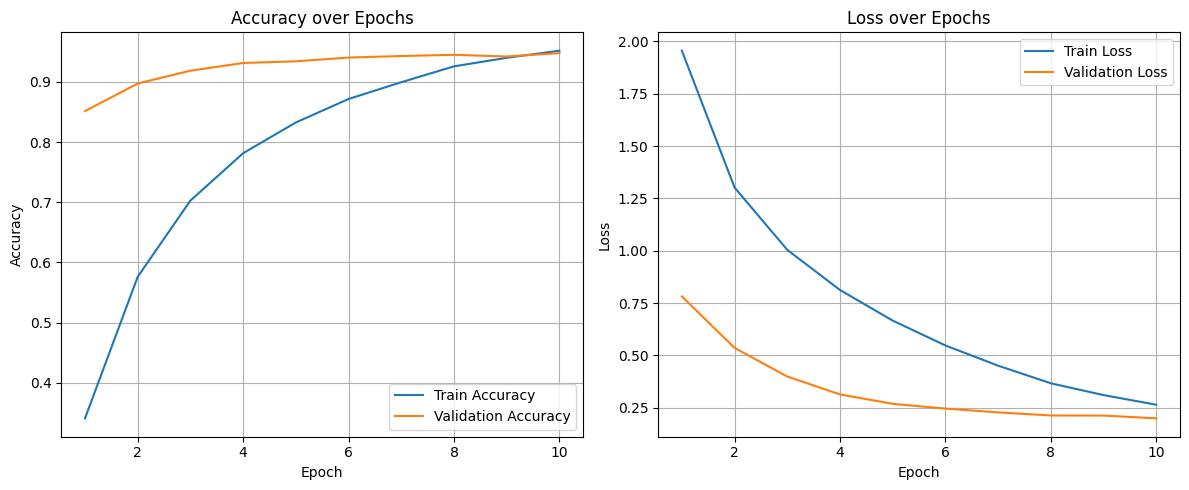

In [14]:
import matplotlib.pyplot as plt

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,      label='Train Accuracy')
plt.plot(epochs, val_acc,  label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,     label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Performance Analysis

1.   Final Val Accuracy	77.51%
2.   Test Accuracy	78.96%
3.   Training Accuracy	77.51%
4.   Val Loss	0.6758



ResNet50 (Model 2)

1.  Final Val Accuracy		94.78%
2.  Test Accuracy		 94.53%
3.  Training Accuracy		95.52%
4.  Val Loss		0.1996



**Observations:**

. Accuracy Performance

ResNet50 dominates across all accuracy metrics (train/val/test)
Achieves 94.6% test accuracy vs CNN's 78.96
2. Training Dynamics

Custom CNN Pros:

Faster training (4s vs 131s per epoch)
Simpler architecture
ResNet50 Pros:

Better convergence (smoother learning curves)
Higher final accuracy
Minimal overfitting (just 1.11% gap vs CNN's 8.39%)
3. Loss Characteristics

ResNet50 shows more stable validation loss (0.2112 vs CNN's 0.6105)
CNN's higher validation loss suggests:
Less generalizable features
Potential need for stronger regularization